In [1]:
import torch
import numpy as np 
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from training import *
from mlxtend.data import mnist_data
from accuracy_compute import *
from data_preparation_easy import *
from data_preparation_hard import *
from network_func import *
from search_parameter import *
import optuna
from CIFAR10_model import *
from CIFAR10_data_preparation import *
from useful_model import *
import sys
sys.path.append('/root/GanLuo/PullSum_MNIST/code/神经网络实验')
from models_complex import *
from resnet_model import resnet18,resnet34,resnet50

In [2]:
model = torch.hub.load('pytorch/vision', 'wide_resnet50_2', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()  # 将模型设置为训练模式
    total_loss = 0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算训练损失和准确性
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

# 测试循环
def test(model, device, test_loader, criterion):
    model.eval()  # 将模型设置为评估模式a
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 在测试过程中不计算梯度
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # 计算准确性
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设已经加载了 CIFAR-10 数据并准备好训练和测试数据
X_train, X_test, y_train, y_test = load_cifar10_data(t7_path='/root/GanLuo/PullSum_MNIST/code/神经网络实验/CIFAR10data/cifar10_original.t7',use_t7_data=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将数据转换为 Tensor 并移动到设备 (GPU 或 CPU)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

pretrained_weights_path = "/root/GanLuo/PullSum_MNIST/code/神经网络实验/state_dicts/resnet18.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model = torch.hub.load('pytorch/vision', 'wide_resnet50_2', pretrained=True)#resnet18(pretrained=False, progress=False, device=device, pretrained_weights_path=pretrained_weights_path)
model.to(device)

lr = 5e-4
batch_size = 128
num_epochs = 50

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

# 创建数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

L1,L2,A1,A2=[], [], [], []

# 运行训练和测试循环
for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    Trian_loss,Trian_accuracy = train(model, device, train_loader, optimizer, criterion)
    Test_loss,Test_accuracy = test(model, device, test_loader, criterion)
    L1.append(Trian_loss)
    L2.append(Test_loss)    
    A1.append(Trian_accuracy)
    A2.append(Test_accuracy)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50]


/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train Loss: 5.3064, Accuracy: 15.35%
Test Loss: 2.6007, Accuracy: 31.10%
Epoch [2/50]
Train Loss: 2.0378, Accuracy: 38.76%
Test Loss: 1.7448, Accuracy: 44.34%
Epoch [3/50]
Train Loss: 1.5244, Accuracy: 49.81%
Test Loss: 1.4697, Accuracy: 51.35%
Epoch [4/50]
Train Loss: 1.2658, Accuracy: 57.63%
Test Loss: 1.2962, Accuracy: 56.97%
Epoch [5/50]
Train Loss: 1.0861, Accuracy: 63.25%
Test Loss: 1.1900, Accuracy: 60.02%
Epoch [6/50]
Train Loss: 0.9522, Accuracy: 67.61%
Test Loss: 1.1177, Accuracy: 63.18%
Epoch [7/50]
Train Loss: 0.8462, Accuracy: 71.06%
Test Loss: 1.0667, Accuracy: 65.07%
Epoch [8/50]
Train Loss: 0.7535, Accuracy: 74.05%
Test Loss: 1.0416, Accuracy: 66.41%
Epoch [9/50]
Train Loss: 0.6808, Accuracy: 76.65%
Test Loss: 1.0233, Accuracy: 67.14%
Epoch [10/50]
Train Loss: 0.6143, Accuracy: 78.94%
Test Loss: 1.0142, Accuracy: 67.71%
Epoch [11/50]
Train Loss: 0.5503, Accuracy: 81.24%
Test Loss: 1.0133, Accuracy: 67.94%
Epoch [12/50]
Train Loss: 0.4965, Accuracy: 83.08%
Test Loss: 1.0

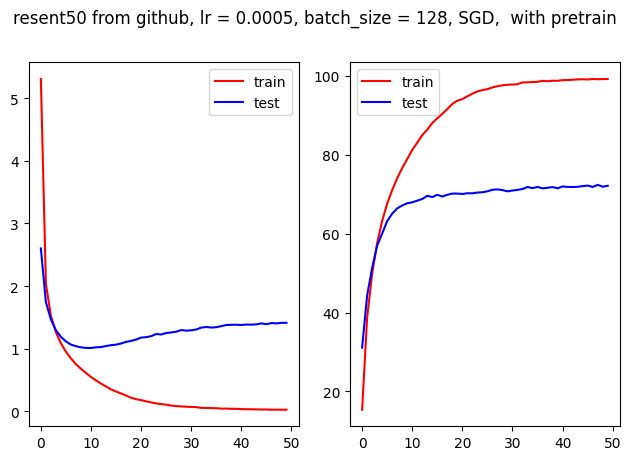

In [5]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent50 from github, lr = {lr}, batch_size = {batch_size}, SGD,  with pretrain')
plt.show()

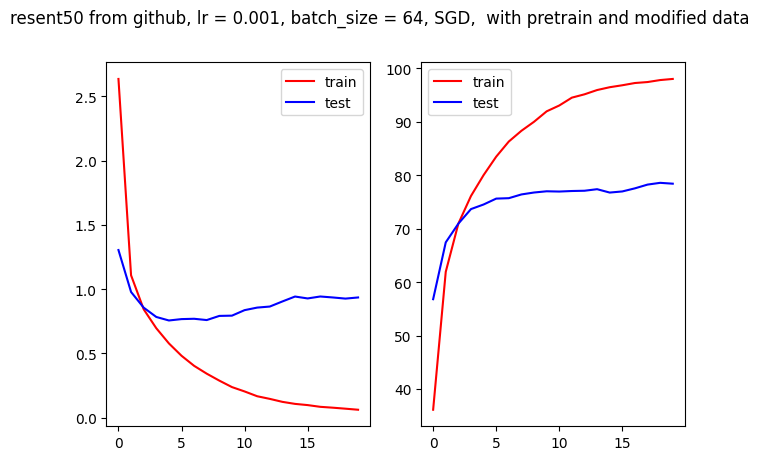

In [7]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent50 from github, lr = {lr}, batch_size = {batch_size}, SGD,  with pretrain and modified data')
plt.show()

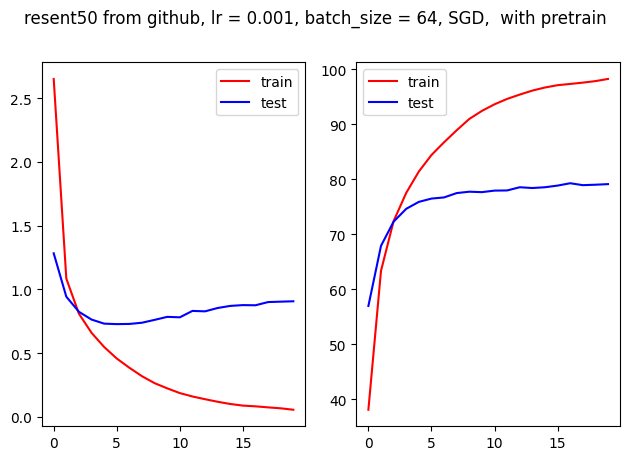

In [10]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent50 from github, lr = {lr}, batch_size = {batch_size}, SGD,  with pretrain')
plt.show()

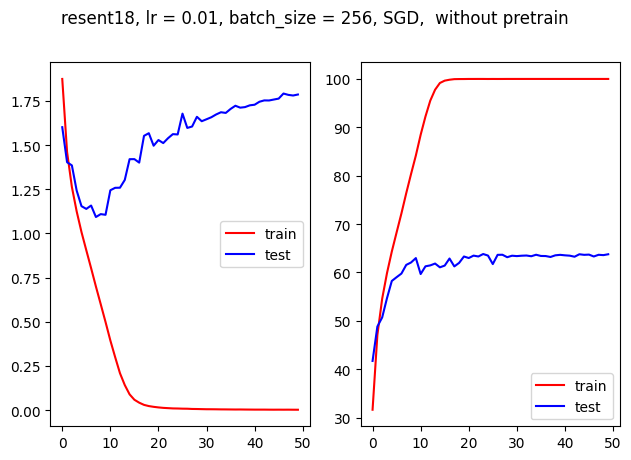

In [4]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent18, lr = {lr}, batch_size = {batch_size}, SGD,  without pretrain')
plt.show()

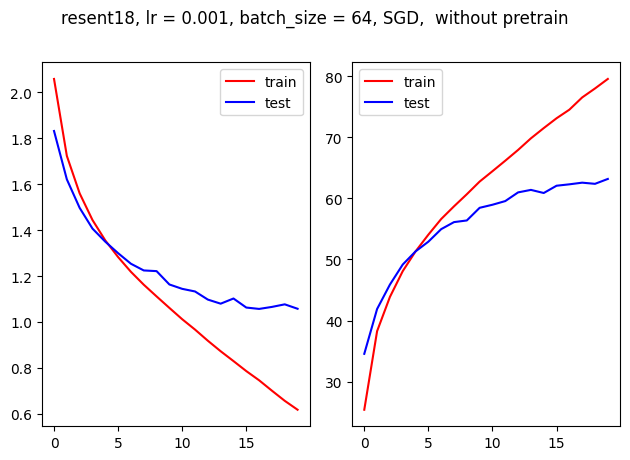

In [6]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent18, lr = {lr}, batch_size = {batch_size}, SGD,  without pretrain')
plt.show()

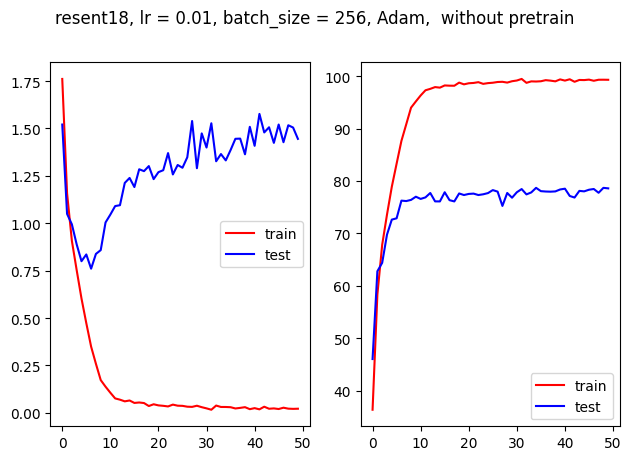

In [4]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent18, lr = {lr}, batch_size = {batch_size}, Adam,  without pretrain')
plt.show()

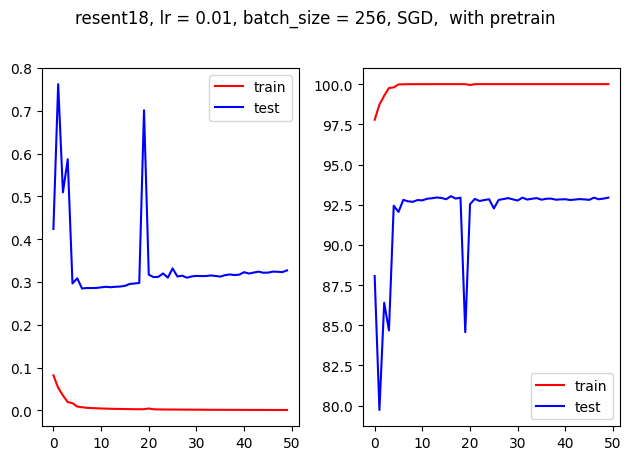

In [6]:
plt.subplot(1,2,1)
plt.plot(L1,color='r',label='train')
plt.plot(L2,color='b',label='test')
plt.legend()

plt.subplot(1,2,2)
plt.plot(A1,color='r',label='train')
plt.plot(A2,color='b',label='test')
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.90]) 
plt.suptitle(f'resent18, lr = {lr}, batch_size = {batch_size}, SGD,  with pretrain')
plt.show()